<a href="https://colab.research.google.com/github/karencfisher/face_express/blob/main/notebooks/vector_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data is from https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The ```icml_face_data.csv``` dataset which contains a total of 34034 samples. It contains 3 columns. The target label is an integer (0, 6), the seven basic emtions:

```
['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
```

The images are stored in the 'pixels' column, as a string of 2304 integer values (0, 255) separated by spaces. These will need be coverted into an array of integer values. Subsequently, they will be needs reshaped into 3-d numpy arrays to be input to the CNN.



In [3]:
def loadCleanData(fname):
    df = pd.read_csv(fname)
    
    # regularize capitalization and remove leading space in column headings
    fix_cols = {s : s.lower().strip() for s in df.columns.to_list()}
    df.rename(columns = fix_cols, inplace=True)
    
    # convert pixels from strings to lists of integers
    df['pixels'] = df['pixels'].apply(lambda x: [int(i) for i in x.split()])
    
    # Not using the 'usage' column, so can be dropped
    df.drop('usage', axis=1, inplace=True)
    
    return df

In [4]:
df = loadCleanData('/content/drive/MyDrive/face express data/icml_face_data.csv')
df.head()

,emotion,pixels
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [5]:
df_labels = pd.read_csv('https://raw.githubusercontent.com/microsoft/FERPlus/master/fer2013new.csv')
df_labels.head()

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0


In [6]:
df_labels = df_labels[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']]
fer2013_new = pd.concat([df, df_labels], axis=1)
fer2013_new = fer2013_new[fer2013_new['NF'] < 10]

fer2013_new.head()

,emotion,pixels,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",4,0,0,1,3,2,0,0,0,0
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",6,0,1,1,0,0,0,0,2,0
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",5,0,0,3,1,0,0,0,1,0
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",4,0,0,4,1,0,0,0,1,0
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",9,0,0,1,0,0,0,0,0,0


In [7]:
# Select all but NF for use
y = fer2013_new[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']].values

# Majority rule
def makeClasses(votes):
  probs = []
  for row in range(votes.shape[0]):
    # put any contempt votes to disgust
    votes[row][5] += votes[row][7]
    y = np.argmax(votes[row][:7])
    probs.append(y)

  return np.array(probs)

In [8]:
classes = ['Neutral', 'Happy', 'Surprise', 'Sad', 'Angry', 'Disgust', 'Fear']

In [20]:
fer2013_new['emotion'] = makeClasses(y)
fer2013_new.head(10)

,emotion,pixels,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF,vector
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",4,0,0,1,3,2,0,0,0,0,"[-5, 12, -4, 20, -3, 27, -1, 34, 1, 40, 7, 44,..."
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",6,0,1,1,0,0,0,0,2,0,"[-1, 18, 0, 24, 1, 30, 3, 35, 5, 40, 8, 45, 13..."
2,0,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",5,0,0,3,1,0,0,0,1,0,"[0, 9, 0, 16, 2, 22, 3, 29, 4, 36, 7, 42, 12, ..."
3,0,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",4,0,0,4,1,0,0,0,1,0,"[4, 10, 4, 16, 5, 21, 5, 27, 6, 33, 9, 38, 12,..."
4,0,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",9,0,0,1,0,0,0,0,0,0,"[-3, 14, -2, 20, -1, 27, 0, 33, 3, 39, 6, 44, ..."
5,0,"[55, 55, 55, 55, 55, 54, 60, 68, 54, 85, 151, ...",6,0,0,1,0,0,1,1,1,0,"[-1, 14, -1, 21, 0, 28, 0, 34, 1, 40, 4, 45, 9..."
6,3,"[20, 17, 19, 21, 25, 38, 42, 42, 46, 54, 56, 6...",2,0,0,8,0,0,0,0,0,0,"[1, 15, 1, 22, 2, 29, 3, 34, 5, 40, 8, 44, 12,..."
7,1,"[77, 78, 79, 79, 78, 75, 60, 55, 47, 48, 58, 7...",0,10,0,0,0,0,0,0,0,0,"[5, 13, 4, 18, 3, 23, 4, 28, 6, 34, 8, 39, 12,..."
8,1,"[85, 84, 90, 121, 101, 102, 133, 153, 153, 169...",0,10,0,0,0,0,0,0,0,0,"[-1, 11, 0, 18, 1, 24, 2, 31, 5, 37, 8, 42, 13..."
9,2,"[255, 254, 255, 254, 254, 179, 122, 107, 95, 1...",0,0,6,0,0,0,4,0,0,0,"[-1, 14, 0, 21, 1, 28, 3, 34, 5, 40, 8, 46, 13..."


In [9]:
import dlib
from imutils import face_utils

!wget https://github.com/italojs/facial-landmarks-recognition/blob/master/shape_predictor_68_face_landmarks.dat?raw=true

--2020-11-22 06:18:58--  https://github.com/italojs/facial-landmarks-recognition/blob/master/shape_predictor_68_face_landmarks.dat?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat [following]
--2020-11-22 06:18:58--  https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat [following]
--2020-11-22 06:18:58--  https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubuserconten

In [10]:
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat?raw=true")

def align(img):
  image = np.array(img, dtype=np.uint8).reshape(48, 48)
  fa = face_utils.FaceAligner(predictor, desiredLeftEye=(.23, .23), desiredFaceWidth=48)
  rect = dlib.rectangle(0, 0, 48, 48)
  aligned_img = fa.align(image, image, rect)
  return aligned_img


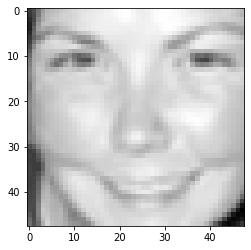

In [11]:
img = align(df.iloc[8]['pixels'])
plt.imshow(img, cmap='gray')

In [12]:
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat?raw=true")

def vectorizeFace(image):
  img = align(image)
  rect = dlib.rectangle(0, 0, 48, 48)
  shapes = predictor(img, rect)
  vect = list(face_utils.shape_to_np(shapes).reshape(136))
  return vect

In [13]:
fer2013_new['vector'] = fer2013_new['pixels'].apply(vectorizeFace)
fer2013_new.head()

,emotion,pixels,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF,vector
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",4,0,0,1,3,2,0,0,0,0,"[-5, 12, -4, 20, -3, 27, -1, 34, 1, 40, 7, 44,..."
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",6,0,1,1,0,0,0,0,2,0,"[-1, 18, 0, 24, 1, 30, 3, 35, 5, 40, 8, 45, 13..."
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",5,0,0,3,1,0,0,0,1,0,"[0, 9, 0, 16, 2, 22, 3, 29, 4, 36, 7, 42, 12, ..."
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",4,0,0,4,1,0,0,0,1,0,"[4, 10, 4, 16, 5, 21, 5, 27, 6, 33, 9, 38, 12,..."
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",9,0,0,1,0,0,0,0,0,0,"[-3, 14, -2, 20, -1, 27, 0, 33, 3, 39, 6, 44, ..."


In [21]:
def visualizeFaceVector(row):
  vector = fer2013_new.iloc[row]['vector']
  vec = np.array(vector).reshape(len(vector) // 2, 2)
  x = [vec[i][0] for i in range(vec.shape[0])]
  y = [vec[i][1] for i in range(vec.shape[0])]
  img = align(fer2013_new.iloc[row]['pixels'])
  plt.figure(figsize=(5,5))
  plt.imshow(img, cmap='gray')
  plt.scatter(x, y, color='red')
  plt.title(classes[fer2013_new.iloc[row]['emotion']])
  plt.show()

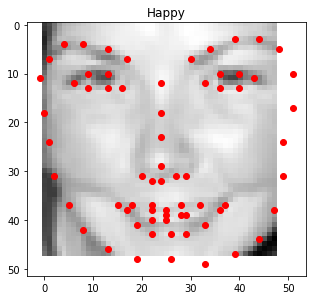

In [22]:
visualizeFaceVector(8)

In [40]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad

In [25]:
x_train, x_test, y_train, y_test = train_test_split(fer2013_new['vector'],
                                                    fer2013_new['emotion'],
                                                    test_size=0.2,
                                                    stratify=fer2013_new['emotion'],
                                                    random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((28568,), (7143,), (28568,), (7143,))

In [26]:
# transform lists of vector values into numpy arrays
x_train = np.vstack(x_train)
x_test = np.vstack(x_test)

# Convert the pandas series of target classes to numpy array
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

x_train.shape, y_train.shape

((28568, 136), (28568,))

In [54]:
model = Sequential([Input(shape=x_train.shape[1:]),
                    Normalization(),
                    Dense(512, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(7, activation='softmax')])

model.compile(optimizer=Adam(lr=.001), loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_9 (Normalizati (None, 136)               273       
_________________________________________________________________
dense_43 (Dense)             (None, 512)               70144     
_________________________________________________________________
dense_44 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_45 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_46 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_47 (Dense)             (None, 7)                 455       
Total params: 243,352
Trainable params: 243,079
Non-trainable params: 273
______________________________________________

In [55]:
stop = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2, min_delta=.001)

history = model.fit(x_train, 
          y_train,
          validation_data=(x_test, y_test),
          epochs=100, 
          batch_size=32, 
          callbacks=[stop, reduce_lr])

Epoch 1/100
893/893 [==============================] - 5s 5ms/step - loss: 1.6766 - acc: 0.4263 - val_loss: 1.5084 - val_acc: 0.4523
Epoch 2/100
893/893 [==============================] - 4s 5ms/step - loss: 1.4341 - acc: 0.4947 - val_loss: 1.3545 - val_acc: 0.5264
Epoch 3/100
893/893 [==============================] - 4s 5ms/step - loss: 1.4035 - acc: 0.5071 - val_loss: 1.3659 - val_acc: 0.5185
Epoch 4/100
893/893 [==============================] - 4s 5ms/step - loss: 1.3820 - acc: 0.5176 - val_loss: 1.3441 - val_acc: 0.5253
Epoch 5/100
893/893 [==============================] - 4s 5ms/step - loss: 1.3516 - acc: 0.5273 - val_loss: 1.3126 - val_acc: 0.5541
Epoch 6/100
893/893 [==============================] - 4s 5ms/step - loss: 1.3473 - acc: 0.5276 - val_loss: 1.3302 - val_acc: 0.5352
Epoch 7/100
893/893 [==============================] - 4s 5ms/step - loss: 1.3444 - acc: 0.5312 - val_loss: 1.3519 - val_acc: 0.5349
Epoch 8/100
893/893 [==============================] - 4s 5ms/step - 

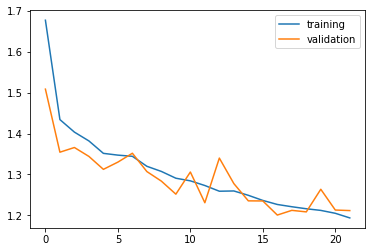

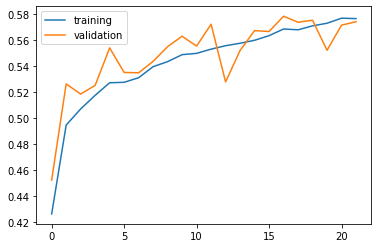

In [56]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.show()

In [57]:
score = model.evaluate(x_test, y_test)[1]
print(f'Accuracy on test {round(score * 100, 2)} %')

224/224 [==============================] - 0s 1ms/step - loss: 1.2009 - acc: 0.5785
Accuracy on test 57.85 %


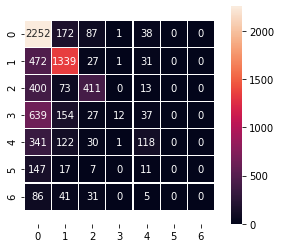

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

preds = model.predict(x_test)
y_pred = [np.argmax(pred) for pred in preds]
cm = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cm, annot=True, fmt='d', linewidths=.2, square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

In [32]:
classes

['Neutral', 'Happy', 'Surprise', 'Sad', 'Angry', 'Disgust', 'Fear']

In [79]:
def showSample():
  index = np.random.randint(0, fer2013_new.shape[0])
  vector = np.array(fer2013_new.iloc[index]['vector'])

  y_preds = model([vector])
  predict = np.argmax(preds[0])
  prob = float(y_preds[0][predict])

  print(predict == fer2013_new.iloc[index]['emotion'])
  print(f'Predicted {classes[predict]}')
  print(f'Confidence {round(prob * 100, 2)} %')
  print(f'Actual {classes[fer2013_new.iloc[index]["emotion"]]}')

  vec = np.array(vector).reshape(len(vector) // 2, 2)
  x = [vec[i][0] for i in range(vec.shape[0])]
  y = [vec[i][1] for i in range(vec.shape[0])]
  img = align(fer2013_new.iloc[index]['pixels'])
  plt.figure(figsize=(5,5))
  plt.imshow(img, cmap='gray')
  plt.scatter(x, y, color='red')
  plt.show()

True
Predicted Neutral
Confidence 28.52 %
Actual Neutral


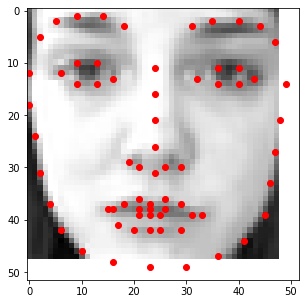

In [94]:
showSample()